In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
import scipy.ndimage as ndimage

In [2]:
def show_all_imgs(imgs, fig_title=None, titles=None, *args, **kwargs):
    """
    Shows all the MRIS for one patient. 
    Args:
        imgs (list): list of all the mris, hopefully ordered but not necessary
        title (list): list of the titles corresponding to the mris
        **kwargs (dict): give the arguments for the figure (typically, figsize)
    """
    fig = plt.figure(**kwargs)
    if fig_title is not None:
        fig.suptitle(fig_title)
    axs = fig.subplots(1, len(imgs))
    for idx, (ax, img) in enumerate(zip(axs, imgs)):
        if titles is not None:
            title = titles[idx]
        else:
            title = idx
        ax.set_title(title)
        ax.imshow(img, cmap='gray')
            
    print('Showing {} figures.'.format(len(imgs)))


def compare_all_imgs(group_imgs, title_group=None, group_titles=None, size_per_img=5, *args, **kwargs):
    for idx, imgs in enumerate(group_imgs):
        if group_titles is not None:
            titles = group_titles[idx]
        else:
            titles = None
        fig_title = None
        if title_group is not None:
            fig_title = title_group[idx]
        show_all_imgs(
            imgs, titles=titles, fig_title=fig_title,
            figsize=(size_per_img*len(imgs), size_per_img), *args, **kwargs)

In [3]:
def get_affine_array_from_params(params):
    """
    Gets the transformation array T such that: new_indexes = T @ old_indexes
    
    Args:
        params (tuple-like): list of strings of a flattened array in the sense (col, col, .., col)
    
    Returns:
        ndarray: transformation array T such that new_indexes = T @ old_indexes
    """
    params = np.array(params).astype(float)

    dim = int( (np.sqrt(1 + 4*len(params) - 1))/2 )
    or_matrix = params[:dim**2].reshape(dim, dim).T
    translation_matrix = params[dim**2:]

    M = np.eye(dim + 1)
    M[:dim,:dim] = or_matrix
    M[:-1, -1] = translation_matrix
    
    return M

def apply_transform(
    ar, 
    T, 
    **kwargs
):
    """
    Apply a transformation array T to each element of array ar. Returns
    ar[T(i)] for indexes i.
    
    Args:
        ar (ndarray): array to transform
        T (ndarray): square array of shape len(ar.shape) + 1
    
    Returns:
        ndarray: same shape as ar. ar[T(i)] for all indexes i, interpolated.
    """
    center = np.array([(shp -1)/2 for shp in ar.shape])

    rot_matrix = T[:-1, :-1]
    trans_matrix = T[:-1, -1]
    offset = trans_matrix - rot_matrix @ center + center
    res = ndimage.affine_transform(ar, rot_matrix, offset=offset, order=0)

    return res

def correct_transform(M, correction):
    """
    When elastix converts numpy array to an image, it changes coordinates (x,   )
    to match standard. We have to correct the output transformation by inverting coordinates
    x and z.
    
    Args:
        M (ndarray): Output transform from elastix
    
    Returns:
        ndarray: corrected transform to apply to numpy images
    """
    M2 = M + 0
    rot = M[:-1, :-1]
    M2[-2, -1], M2[0, -1] = M2[0, -1], M2[-2, -1]   # translation x <-> z        
    M2[:-1,:-1] = rot[::-1, ::-1]                 
    return M2

# Elastix Transform Parameters

How does elastix handle the transform parameters? How to pass from the transform parameters `trans['TransformParameters']`, in SimpleITK Image type, to the affine matrix to transform indexes in numpy?

In [9]:
path_to_transform_file = "ExampleTransform.txt"

Showing 4 figures.


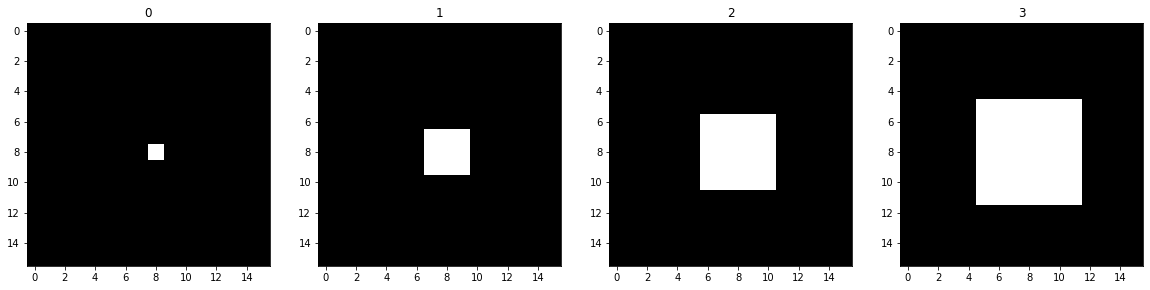

In [10]:
# Create cube
cube = np.zeros((16, 16, 4))
mid_idx = [16 // 2, 16 // 2]
for i in range(cube.shape[2]):
    cube[mid_idx[0] - i:mid_idx[0]+i+1, mid_idx[1] - i:mid_idx[1]+i+1, i] = 1
show_all_imgs(cube.transpose(2,0,1), figsize=(5*cube.shape[-1], 5))    

In [11]:
# Get affine transform
affine_trans = sitk.ReadParameterFile(path_to_transform_file)

In [12]:
%%time
# Apply transformix transform
itk_cube = sitk.GetImageFromArray(cube)
resultCube = sitk.Transformix(itk_cube, affine_trans)
itk_res = sitk.GetArrayFromImage(resultCube)

CPU times: user 8.71 ms, sys: 0 ns, total: 8.71 ms
Wall time: 30.1 ms


In [13]:
%%time
# Apply numpy transform
T_itk = get_affine_array_from_params(affine_trans['TransformParameters'])

T_numpy = correct_transform(T_itk, correction='invert_xz')
res_numpy = apply_transform(cube, T_numpy)


CPU times: user 2.12 ms, sys: 387 µs, total: 2.5 ms
Wall time: 1.51 ms


In [16]:
print(np.round(T_itk, 2))
print(np.round(T_numpy, 2))

[[ 0.98 -0.17  0.09  1.  ]
 [ 0.17  0.98  0.    3.  ]
 [-0.09  0.02  1.    2.  ]
 [ 0.    0.    0.    1.  ]]
[[ 1.    0.02 -0.09  2.  ]
 [ 0.    0.98  0.17  3.  ]
 [ 0.09 -0.17  0.98  1.  ]
 [ 0.    0.    0.    1.  ]]


Showing 4 figures.
Showing 4 figures.
Showing 4 figures.


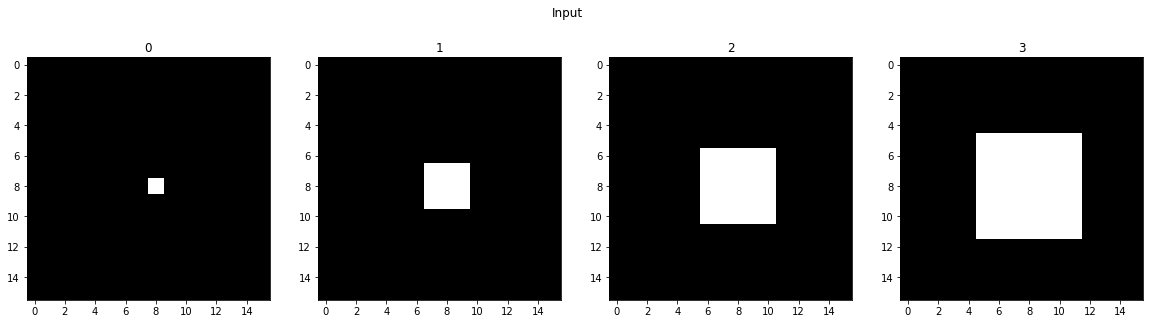

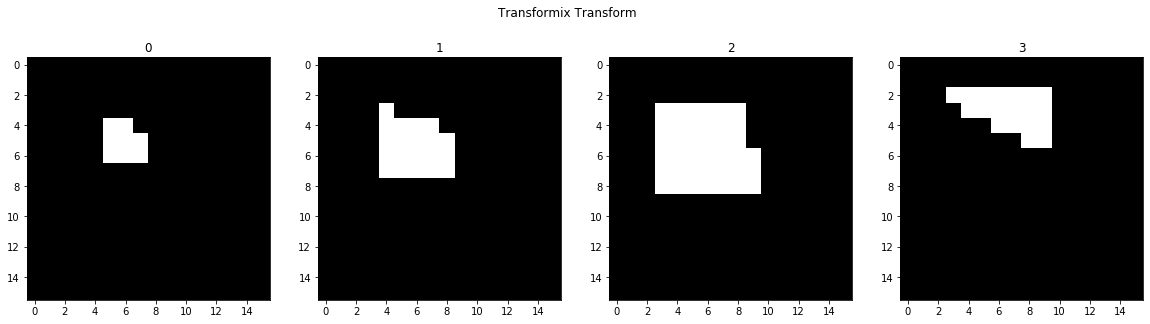

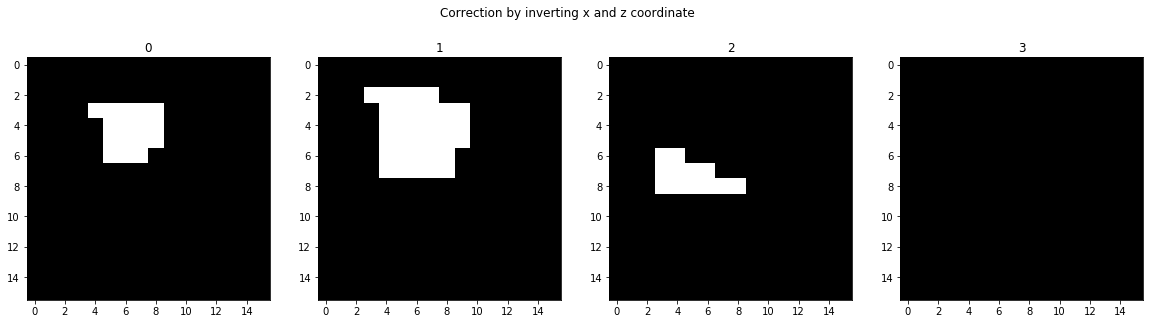

In [15]:
compare_all_imgs(
    [
        cube.transpose(2,1,0),
        itk_res.transpose(2,1,0),
        res_numpy.transpose(2,1,0)
    ],
    [
        'Input',
        'Transformix Transform',
        'Correction by inverting x and z coordinate',
    ]

)